In [42]:
import gradio as gr
import os

from dotenv import load_dotenv
from pymilvus import utility, connections

load_dotenv()

ZILLIZ_URI = os.getenv("ZILLIZ_URI")
ZILLIZ_TOKEN = os.getenv("ZILLIZ_TOKEN")

In [43]:
connections.connect(uri=ZILLIZ_URI, token=ZILLIZ_TOKEN)

In [44]:
import torch
from torch import nn, tensor
from transformers import AutoFeatureExtractor, SegformerForSemanticSegmentation
import matplotlib.pyplot as plt
from torchvision.transforms import Resize
import torchvision.transforms as T
from torchvision.ops import masks_to_boxes
from torchvision.transforms.functional import crop
import time
import glob
from PIL import Image
import sys

In [45]:
# run this before importing the resnet50 model if you run into an SSL certificate URLError
import ssl
ssl._create_default_https_context = ssl._create_unverified_context

# Load the embedding model with the last layer removed
embeddings_model = torch.hub.load('NVIDIA/DeepLearningExamples:torchhub', 'nvidia_resnet50', pretrained=True)
embeddings_model = torch.nn.Sequential(*(list(embeddings_model.children())[:-1]))
embeddings_model.eval()
extractor = AutoFeatureExtractor.from_pretrained("mattmdjaga/segformer_b2_clothes")
segmentation_model = SegformerForSemanticSegmentation.from_pretrained("mattmdjaga/segformer_b2_clothes")


Using cache found in /Users/yujiantang/.cache/torch/hub/NVIDIA_DeepLearningExamples_torchhub
/Users/yujiantang/Documents/workspace/fashionai/fai/lib/python3.10/site-packages/transformers/models/segformer/feature_extraction_segformer.py:28: FutureWarning: The class SegformerFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use SegformerImageProcessor instead.
  warnings.warn(
/Users/yujiantang/Documents/workspace/fashionai/fai/lib/python3.10/site-packages/transformers/models/segformer/image_processing_segformer.py:101: FutureWarning: The `reduce_labels` parameter is deprecated and will be removed in a future version. Please use `do_reduce_labels` instead.
  warnings.warn(


In [46]:
DIMENSION = 2048
BATCH_SIZE = 128
COLLECTION_NAME = "TSwizzleFashionComparison"

In [47]:
# if running for the second time, no need to re-upload images
from pymilvus import FieldSchema, CollectionSchema, Collection, DataType

collection = Collection(name=COLLECTION_NAME)
collection.load()

In [48]:
wanted = [1, 3, 4, 5, 6, 7, 8, 9, 10, 16, 17]
def get_segmentation(image):
    inputs = extractor(images=image, return_tensors="pt")

    outputs = segmentation_model(**inputs)
    logits = outputs.logits.cpu()

    upsampled_logits = nn.functional.interpolate(
        logits,
        size=image.size[::-1],
        mode="bilinear",
        align_corners=False,
    )

    pred_seg = upsampled_logits.argmax(dim=1)[0]
    return pred_seg 

# returns two lists masks (tensor) and obj_ids (int)
# "mattmdjaga/segformer_b2_clothes" from hugging face
def get_masks(segmentation):
    obj_ids = torch.unique(segmentation)
    obj_ids = obj_ids[1:]
    wanted_ids = [x.item() for x in obj_ids if x in wanted]
    # print(obj_ids)
    # print(wanted_ids)
    wanted_ids = torch.Tensor(wanted_ids)
    # print(wanted_ids)
    masks = segmentation == wanted_ids[:, None, None]
    return masks, obj_ids

def crop_images(masks, obj_ids, img):
    boxes = masks_to_boxes(masks)
    crop_boxes = []
    for box in boxes:
        crop_box = tensor([box[0], box[1], box[2]-box[0], box[3]-box[1]])
        crop_boxes.append(crop_box)
    
    preprocess = T.Compose([
        T.Resize(size=(256, 256)),
        T.ToTensor()
    ])
    
    cropped_images = []
    seg_ids = []
    for i in range(len(crop_boxes)):
        crop_box = crop_boxes[i]
        cropped = crop(img, crop_box[1].item(), crop_box[0].item(), crop_box[3].item(), crop_box[2].item())
        cropped_images.append(preprocess(cropped))
        seg_ids.append(obj_ids[i].item())
    with torch.no_grad():
        embeddings = embeddings_model(torch.stack(cropped_images)).squeeze().tolist()
    return embeddings, boxes.tolist(), seg_ids


In [49]:
import gradio as gr
import os
import numpy as np

def get_cmap(n, name='hsv'):
    '''Returns a function that maps each index in 0, 1, ..., n-1 to a distinct 
    RGB color; the keyword argument name must be a standard mpl colormap name.
    Sourced from https://stackoverflow.com/questions/14720331/how-to-generate-random-colors-in-matplotlib'''
    return plt.cm.get_cmap(name, n)

def match(image):
    # Create the result subplots
    f, axarr = plt.subplots(1, CLOSEST+1) 

    # Generate crops and embeddings for all items found
    # image = Image.open(path)
    segmentation = get_segmentation(image)
    masks, ids = get_masks(segmentation)
    embeddings, crop_corners, _ = crop_images(masks, ids, image)

    # Generate color map
    cmap = get_cmap(len(crop_corners))

    # Display the first box with image being searched for
    axarr[0].imshow(image)
    axarr[0].set_title('Search Image')
    axarr[0].axis('off')
    for i, (x0, y0, x1, y1) in enumerate(crop_corners):
        rect = patches.Rectangle((x0, y0), x1-x0, y1-y0, linewidth=1, edgecolor=cmap(i), facecolor='none')
        axarr[0].add_patch(rect)
    
    # print(embeddings)
    # print(type(embeddings))
    # Search the database for all the crops
    start = time.time()
    res = collection.search(embeddings, 
       anns_field='embedding', 
       param={"metric_type": "L2",
              "params": {"nprobe": 3}, "offset": 0}, 
       limit=LIMIT, 
       output_fields=['filepath', 'crop_corner'])
    finish = time.time()

    print("Total Search Time: ", finish - start)
    # print(res)

    # Summarize the top unique results and weight them based on position in results
    filepaths = []
    for hits in res:
        seen = set()
        for i, hit in enumerate(hits):
            if hit.entity.get("filepath") not in seen:
                seen.add(hit.entity.get("filepath"))
                filepaths.extend([hit.entity.get("filepath") for _ in range(len(hits) - i)])
    
    # Find the most commonly ranked result image
    counts = Counter(filepaths)
    most_common = [path for path, _ in counts.most_common(CLOSEST)]
    
    # For each image, extract the corresponding item found that correlates to search images
    matches = {}
    for i, hits in enumerate(res):
        matches[i] = {}
        tracker = set(most_common)
        for hit in hits:
            if hit.entity.get("filepath") in tracker:
                matches[i][hit.entity.get("filepath")] = hit.entity.get("crop_corner")
                tracker.remove(hit.entity.get("filepath"))
   
    # Display the most common images in results
    for res_i, res_path in enumerate(most_common):
        # Display each of the images next to search image
        image = Image.open(res_path)
        axarr[res_i+1].imshow(image)
        axarr[res_i+1].set_title(" ".join(res_path.split("/")[2].split("_")))
        axarr[res_i+1].axis('off')
        # Add bounding boxes for all matched items
        for key, value in matches.items():
            if res_path in value:
                x0, y0, x1, y1 = value[res_path]
                rect = patches.Rectangle((x0, y0), x1-x0, y1-y0, linewidth=1, edgecolor=cmap(key), facecolor='none')
                axarr[res_i+1].add_patch(rect)

    f.savefig("plot.png")
    image = Image.open("plot.png")
    return image

demo = gr.Interface(
    match,
    gr.Image(type="pil"),
    "image",
    flagging_options=["blurry", "incorrect", "other"],
    examples=[
        "photos/Taylor_Swift/Taylor_Swift_1.jpg",
        "photos/Taylor_Swift/Taylor_Swift_2.jpg",
        "photos/Taylor_Swift/Taylor_Swift_3.jpg",
        "photos/Taylor_Swift/Taylor_Swift_4.jpg",
    ],
)

if __name__ == "__main__":
    demo.launch(share=True)

Running on local URL:  http://127.0.0.1:7885
Running on public URL: https://4dbc0762bf72200188.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from Terminal to deploy to Spaces (https://huggingface.co/spaces)


/var/folders/w0/tssy0xz54jld1pjjx8pl73lm0000gn/T/ipykernel_91827/2806616005.py:9: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  return plt.cm.get_cmap(name, n)


Total Search Time:  0.05564689636230469


/var/folders/w0/tssy0xz54jld1pjjx8pl73lm0000gn/T/ipykernel_91827/3261223268.py:16: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  return plt.cm.get_cmap(name, n)


Total Search Time:  0.04277515411376953
['["id: 444203465593182447, distance: 289.5531921386719, entity: {\'filepath\': \'./photos/Taylor_Swift/Taylor_Swift_8.jpg\', \'crop_corner\': [326.0, 297.0, 921.0, 994.0]}", "id: 444203465593182482, distance: 332.68646240234375, entity: {\'filepath\': \'./photos/Taylor_Swift/Taylor_Swift_4.jpg\', \'crop_corner\': [309.0, 289.0, 729.0, 759.0]}", "id: 444203465593182486, distance: 379.35455322265625, entity: {\'filepath\': \'./photos/Taylor_Swift/Taylor_Swift_6.jpg\', \'crop_corner\': [640.0, 543.0, 1136.0, 1373.0]}", "id: 444203465593182488, distance: 392.0845947265625, entity: {\'filepath\': \'./photos/Taylor_Swift/Taylor_Swift_6.jpg\', \'crop_corner\': [871.0, 858.0, 1126.0, 1566.0]}", "id: 444203465593182442, distance: 425.3915710449219, entity: {\'filepath\': \'./photos/Taylor_Swift/Taylor_Swift_9.jpg\', \'crop_corner\': [512.0, 830.0, 1094.0, 1477.0]}"]', '["id: 444203465593182467, distance: 355.0014343261719, entity: {\'filepath\': \'./phot

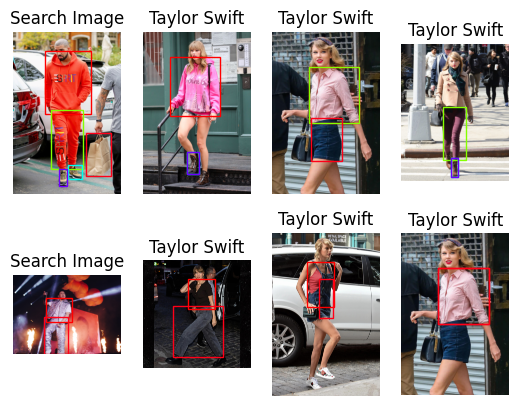

In [16]:
from pprint import pprint
from PIL import ImageDraw
from collections import Counter
import matplotlib.patches as patches
import matplotlib.pyplot as plt

LIMIT = 5  # How many closes matches per article of clothing to analyze
CLOSEST = 3 # How many closest images to display. CLOSEST <= Limit

search_paths = ["./photos/Drake/Drake_6.jpg", "./photos/Rich_Brian/Rich_Brian_8.jpg"] # Images to search for

def get_cmap(n, name='hsv'):
    '''Returns a function that maps each index in 0, 1, ..., n-1 to a distinct 
    RGB color; the keyword argument name must be a standard mpl colormap name.
    Sourced from https://stackoverflow.com/questions/14720331/how-to-generate-random-colors-in-matplotlib'''
    return plt.cm.get_cmap(name, n)

# Create the result subplots
f, axarr = plt.subplots(max(len(search_paths), 2), CLOSEST + 1) 

for search_i, path in enumerate(search_paths):

    # Generate crops and embeddings for all items found
    image = Image.open(path)
    segmentation = get_segmentation(image)
    masks, ids = get_masks(segmentation)
    embeddings, crop_corners, _ = crop_images(masks, ids, image)

    # Generate color map
    cmap = get_cmap(len(crop_corners))

    # Display the first box with image being searched for
    axarr[search_i][0].imshow(image)
    axarr[search_i][0].set_title('Search Image')
    axarr[search_i][0].axis('off')
    for i, (x0, y0, x1, y1) in enumerate(crop_corners):
        rect = patches.Rectangle((x0, y0), x1-x0, y1-y0, linewidth=1, edgecolor=cmap(i), facecolor='none')
        axarr[search_i][0].add_patch(rect)
    # print(embeddings)
    # print(type(embeddings))
    # Search the database for all the crops
    start = time.time()
    res = collection.search(embeddings, 
       anns_field='embedding', 
       param={"metric_type": "L2",
              "params": {"nprobe": 10}, "offset": 0}, 
       limit=LIMIT, 
       output_fields=['filepath', 'crop_corner'])
    finish = time.time()

    print("Total Search Time: ", finish - start)
    # print(res)

    # Summarize the top unique results and weight them based on position in results
    filepaths = []
    for hits in res:
        seen = set()
        for i, hit in enumerate(hits):
            if hit.entity.get("filepath") not in seen:
                seen.add(hit.entity.get("filepath"))
                filepaths.extend([hit.entity.get("filepath") for _ in range(len(hits) - i)])
    
    # Find the most commonly ranked result image
    counts = Counter(filepaths)
    most_common = [path for path, _ in counts.most_common(CLOSEST)]
    
    # For each image, extract the corresponding item found that correlates to search images
    matches = {}
    for i, hits in enumerate(res):
        matches[i] = {}
        tracker = set(most_common)
        for hit in hits:
            if hit.entity.get("filepath") in tracker:
                matches[i][hit.entity.get("filepath")] = hit.entity.get("crop_corner")
                tracker.remove(hit.entity.get("filepath"))
   
    # Display the most common images in results
    for res_i, res_path in enumerate(most_common):
        # Display each of the images next to search image
        image = Image.open(res_path)
        axarr[search_i][res_i+1].imshow(image)
        axarr[search_i][res_i+1].set_title(" ".join(res_path.split("/")[2].split("_")))
        axarr[search_i][res_i+1].axis('off')
        # Add boudning boxes for all matched items
        for key, value in matches.items():
            if res_path in value:
                x0, y0, x1, y1 = value[res_path]
                rect = patches.Rectangle((x0, y0), x1-x0, y1-y0, linewidth=1, edgecolor=cmap(key), facecolor='none')
                axarr[search_i][res_i+1].add_patch(rect)

plt.show()